## Model Your Customers' Lifetime Value

### Customer LifeTime Value

Lifetimes can be used to analyze our customers based on a few assumption:

Customers interact with us when they are “alive”.

Customers under study may “die” after some period of time.

I’ve quoted “alive” and “die” as these are the most abstract terms (they are used similarly to “birth” and “death” in survival analysis). Whenever we have individuals repeating occurrences, we can use Lifetimes to help understand users behaviour.

### Specific Application: Customer Lifetime Value
As emphasized by P. Fader and B. Hardie, understanding and acting on customer lifetime value (CLV) is the most important part of our business’s sales efforts.

Lifetimes is a Python library to calculate CLV. This is what we are doing today: Calculating CLV with Python.

In [1]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
import pandas as pd
from scipy.stats import beta, gamma, invgamma, norm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
from random import uniform 
from statsmodels.api import OLS
import numpy as np
warnings.filterwarnings('ignore')
%cd
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})

C:\Users\Susan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


C:\Users\Susan


In [2]:
trans_data = pd.read_csv('orders.csv')
%matplotlib inline

In [3]:
trans_data.head()

,Customer ID,Date,Subtotal,State,Country
0,34,6/21/2007,86.0,ON,Canada
1,38,6/27/2007,38.4,ON,Canada
2,47,7/2/2007,53.5,MO,United States
3,61,7/14/2007,7.0,ON,Canada
4,78,7/21/2007,55.5,ON,Canada


In [4]:
trans_data.dtypes

Customer ID      int64
Date            object
Subtotal       float64
State           object
Country         object
dtype: object

In [6]:
trans_data['Date'] = pd.to_datetime(trans_data['Date'])
print('Number of Entries: %s' % len(trans_data))

Number of Entries: 22408


In [7]:
trans_data.dtypes

Customer ID             int64
Date           datetime64[ns]
Subtotal              float64
State                  object
Country                object
dtype: object

In [9]:
trans_data['Date'].min()

Timestamp('2007-06-21 00:00:00')

In [10]:
trans_data['Date'].max()

Timestamp('2015-12-19 00:00:00')

In [11]:
data = summary_data_from_transaction_data(trans_data, 'Customer ID', 'Date', monetary_value_col='Subtotal', observation_period_end='2015-12-31')
data.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
7,2.0,794.0,1117.0,7.57
9,0.0,0.0,3062.0,0.00
30,0.0,0.0,3037.0,0.00
34,0.0,0.0,3115.0,0.00
38,0.0,0.0,3109.0,0.00


* Frequency represents the number of repeat purchases the customer has made. This means that it's one less than the total number of purchases. 

* T represents the age of the customer in whatever time units chosen (daily, in the above dataset). This is equal to the duration between a customer's first purchase and the end of the period under study.

* Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer's first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

The unit of time is in days in our data

count    3498.000000
mean        2.605489
std         2.996117
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        43.000000
Name: frequency, dtype: float64


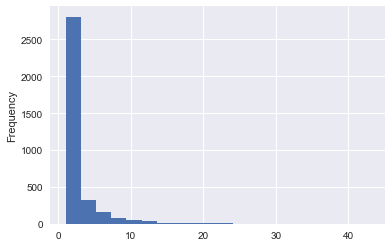

In [12]:
data[data['frequency'] > 0]['frequency'].plot(kind='hist', bins=20)
print(data[data['frequency'] > 0]['frequency'].describe())

In [16]:
print(sum(data['frequency'] == 0)/float(len(data)))

0.727336503235


Most customers are one time buyers, that is 72.7% of customers only make one purchase. Below we look at their recency distribution:

0.727336503235
count    3498.000000
mean      441.194969
std       511.513487
min         1.000000
25%        55.000000
50%       245.500000
75%       661.000000
max      2923.000000
Name: recency, dtype: float64


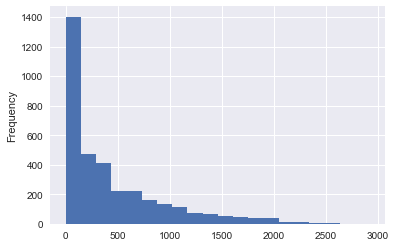

In [15]:
data[data['recency'] != 0]['recency'].plot(kind='hist', bins=20)
print(sum(data['recency'] == 0)/float(len(data)))
print(data[data['recency'] != 0]['recency'].describe())

Customers that have a frequency of zero (customers that have not made repeat purchases) also have a recency of zero so we isolate for repeat customer only. Considering the analysis ranges within a span of eight years, having 50% of your customer churn before a year (245) is even up and 75% of your customers churn before two years (661) should be a concern.

In [17]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'], )
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 12829 subjects, a: 1.31, alpha: 25.33, b: 1.96, r: 0.09>


### Fitting the BG/NBD Model
In quick summary, the BG/NBD model assumes that each customer makes repeat purchases at different intervals. This interval between purchases is modeled by an exponential distribution with a transaction rate $\lambda$. Furthermore, after each transaction, the customer has a $p%$ chance of going inactive (or dying) which is modelled by a shifted Geometric distribution. These two major parameters are further refined for heterogenity across customers through a Gamma distribution for $\lambda$ and a Beta distribution for $p$. Thus we have four total parameters $r$, $\alpha$ (gamma distro) and $a$, $b$ (Beta distro) estimated below:

(0.0, 0.02)

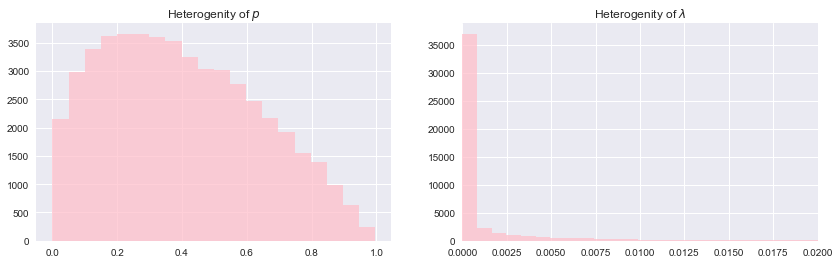

In [18]:
gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd, 20, facecolor='pink', alpha=0.75)
plt.subplot(122)
plt.title('Heterogenity of $\lambda$')
temp = plt.hist(ggd, 500, facecolor='pink', alpha=0.75)
plt.xlim(0.0,0.02)

Since everything goes back to the two major parameters, we can use our heterogenity parameters to model the uncertainty in the two. As shown above, the probability of a customer dropping out has a large range but mostly centered between 15% to 60% after a certain transaction. On the other hand, our customer transaction rate falls mostly within 0 and 0.01.

### Fact Checking
Peter Fader in his Youtube talk on CLV provides four simple plots to illustrate the accuracy of the model and its associated behavioral story when applied to real data sets. I will replicate two of them below on our data to ensure that the model is indeed a good fit for our customers.

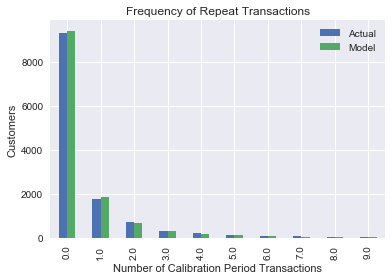

In [24]:
plot_period_transactions(bgf, max_frequency=10)

After fitting the BG/NBD model, we can fact check through looking at the fitted repeat purchase for the entire customer database. Above plots the Actual repeat purchase frequency versus the Model repeat purchase frequency. As shown, the model performs relatively well in fitting the repeat purchase pattern. It overestimates one and six repeat purchases while underestimating three repeat purchases.

In [25]:
trans_data['Date'].min()

Timestamp('2007-06-21 00:00:00')

In [26]:
trans_data['Date'].max()

Timestamp('2015-12-19 00:00:00')

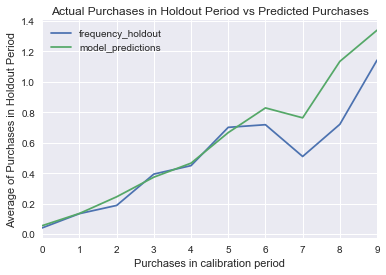

In [27]:
summary_cal_holdout = calibration_and_holdout_data(trans_data, 'Customer ID', 'Date', 
                                        calibration_period_end='2015-01-01',
                                        observation_period_end='2015-12-19' )   
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=10)

We can further validate our model by checking for presence of overfitting. Separating our dataset into two sets: training (2007- 2014 end) and test (2015), we can fit our model with training and see how well it forecasts our customer's out of sample purchasing habit. The plot above shows our fitted model prediction (green) versus our out of sample repeat purchase frequency (blue). Each tick on the x-axis is composed of customers that have been grouped such that they have had $x$ repeat purchases. the Y axis shows the mean of that group's subsequent repeat purchase. For example, for all customers within our training period that have had 4 repeat purchases, the same group had on average about 0.42 purchases and the model predicted the same as well. From this plot, we can see that the model performs relatively well in identifying repeat purchases within the lower ranges (less than 6) but is unable to properly forecast buying behaviors of customers with more frequent purchasing habits.

### R/F Matrix Plots

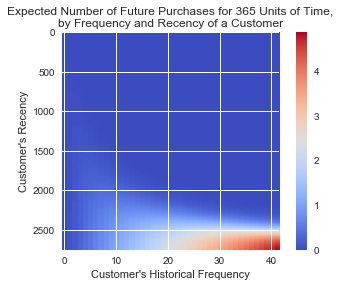

In [30]:
plot_frequency_recency_matrix(bgf, T=365)

We can see that if a customer has bought 30 times from us, and their latest purchase was when they were 2500 days old (given the individual is 2500 days old), then they are your best customer (bottom-right). Our coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven't seen them in ages.

There's also that beautiful "tail" around (10,2000). That represents the customer who buys infrequently, but we've seen him or her recently, so they might buy again - we're not sure if they are dead or just between purchases.

Another interesting matrix to look at is the probability of still being alive:

For a given random customer with his/her observed $(x,t_x)$, we can calculate the probability as of today that they are still alive. In other words, are they still interested in maintaining a purchasing relationship with our company in the future? According to the model, it's very likely as long as they bought recently. Even if they only bought once, they have about a 60-70% chance that they will buy again in the future. Customers that are considered dead are usually ones that haven't made an order in a while.

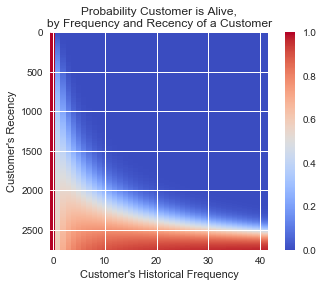

In [31]:
plot_probability_alive_matrix(bgf)

It is interesting to note that for a given recency, customer's with more frequency are more likely to be considered dead. This is a property of the model that illustrates a clear behavioral story: If we observe customers making more frequent purchases, then having a prolonged period of inactivity makes it very likely that they've died off. For example, Two customers $A$ and $B$ that both last purchased 1.5 years ago ($t_x\approx 2700$) but purchased 10 and 30 times respectively. We believe that it is more likely that customer B has died ($p=0.0$) while customer A still has a fair chance of being alive and making purchases in the future ($p\approx 0.4$).

### Analyzing Customer's Historical Path
One last plot that was developed in lifetimes allows us to fully appreciate the model at a granular customer-base level. Indeed, we can observe each of our customer's historical purchasing path and measure our confidence that they have not dropped out in between purchases. To get a small and relevant subsample, I will let the bgf model create projections for the next month purchasing pattern of my entire current customer-base and pick out 6 of my best customers. As shown, our best customers that are projected to make more future repeat purchases are often our newest ones. This makes sense since the model has revealed to us before that our customer base has a tendency to drop off after a short period of time.

In [33]:
t = 31
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
best_projected_cust = data.sort_values('predicted_purchases').tail(6)
print(data.sort_values('predicted_purchases').tail(6))

             frequency  recency      T  monetary_value  predicted_purchases
Customer ID                                                                
10920             19.0    757.0  801.0       61.354211             0.593734
13527             11.0    318.0  348.0      103.427273             0.693523
14008              9.0    242.0  261.0      124.136667             0.749611
12780             14.0    445.0  461.0      110.073571             0.761943
13577             12.0    247.0  275.0       55.782500             0.893935
14263             17.0    198.0  219.0      323.521176             1.521947


Next, we can plot these six individuals over the course of their lifetime to observe their purchasing behavior. Among these top 6 customers, they are sorted by expected future purchases ascendingly. Adding a one month cushion, we can infer the probability that these customers are alive or dead if we have not seen them purchase by the end of the month. For example, for customer $\tt{14263}$ with a short life-time but very recent purchases, we expect him/her to return and buy at-leasts once during the month of January. If however, we don't see this person make an order by the middle of Jan 2016, there is a good chance that they're dead.

Looking at the overall picture, there's not much pattern that can be generalized across all 6 individuals but we can identify certain seasonal behaviors for certain people, for example:

Customer $\tt{13577}$ tends to buy at an equal interval with the exception between September 2015 and Nov 2015.
Customers $\tt{12780}$,  $\tt{13527}$ and $\tt{10920}$ tends to buy during the early stage of their life-cycle and then repeat at a much slower interval
Customer $\tt{14008}$ first bought at a slower interval but increased his/her frequency over time. We can reasonably assume that they started bying more as their business expanded and became more successful.

### Customer Probability Histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example:

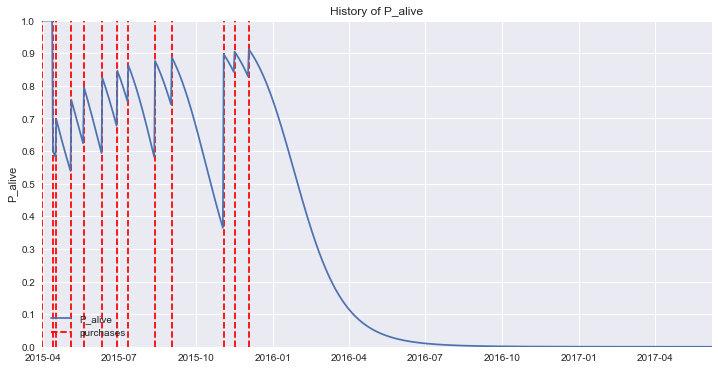

In [40]:
fig = plt.figure(figsize=(12,6))
id = 13577
days_since_birth = 801
sp_trans = trans_data.loc[trans_data['Customer ID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Date')

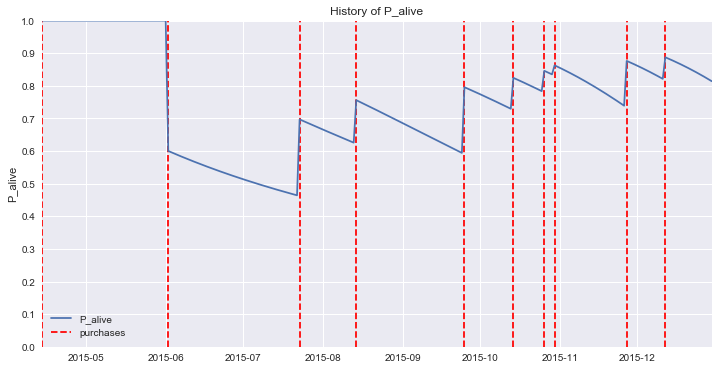

In [41]:
fig = plt.figure(figsize=(12,6))
id = 14008
days_since_birth = 261
sp_trans = trans_data.loc[trans_data['Customer ID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Date')

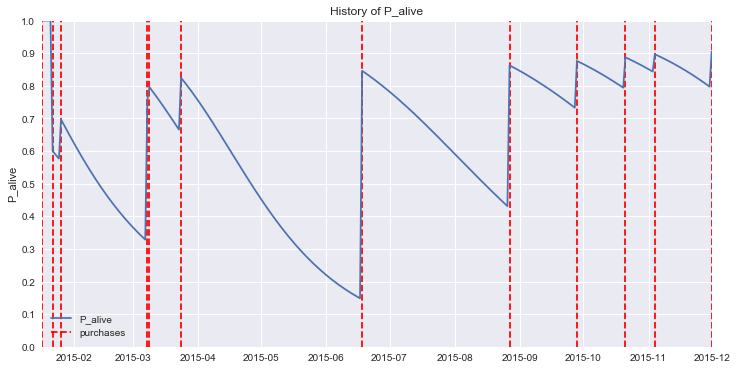

In [43]:
fig = plt.figure(figsize=(12,6))
id = 13527
days_since_birth = 275
sp_trans = trans_data.loc[trans_data['Customer ID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Date')

### Customer Value in Dollars: The Gamma-Gamma Model
In a traditional RFM matrix, each customer can be assigned a monetary value with his or her customer profile. This value is usually calculated as the mean transaction value of his or her purchasing history. Transaction value is a loosely based word around any metric that the business might be interested in. Zakka Canada reports an average profit margin of 55%, I will multiply that by the revenue. Note that we are only interested in customers that have repeat purchases.

In [46]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())

             frequency  recency       T  monetary_value  predicted_purchases
Customer ID                                                                 
7                  2.0    794.0  1117.0           7.570             0.030012
64                 1.0    772.0  3037.0         131.190             0.002833
101                1.0     38.0  2348.0          34.860             0.000410
115                6.0   2593.0  3016.0         144.915             0.042516
129                1.0    736.0  3041.0          14.520             0.002722


### The Gamma-Gamma model and the independence assumption
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [47]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.065976
frequency,0.065976,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [48]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 3498 subjects, p: 2.66, q: 3.06, v: 72.63>


We can now estimate the average transaction value:

In [51]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

Customer ID
7     31.633017
9     93.759145
30    93.759145
34    93.759145
38    93.759145
41    93.759145
47    93.759145
48    93.759145
53    93.759145
61    93.759145
dtype: float64
